In [1]:
import numpy as np
import random
import torch
import sklearn
random_seed = 1968
# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for Python built-in random module
random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)

# Set random seed for Scikit-learn
sklearn.utils.check_random_state(random_seed)


RandomState(MT19937) at 0x20775DB2D40

# Preping annotations

In [2]:
import pandas as pd

current_annotations_file = "../../data/intermediate/annotations/personne_withSentence_1400annotations_2024-03-27_ActiveTigger.csv"

annotations_file = pd.read_csv(current_annotations_file, dtype = {'sentence_id':'int', 
'Personne':'str','sentence':'str'}).set_index('sentence_id')

annotations_file.head(5)

,Personne,sentence
sentence_id,,
1220587,Corps humain,Il importe donc de tenir compte de toutes les ...
1360306,Personne responsable et autonome,Ces personnes donnent un consentement qui relè...
580205,Personne responsable et autonome,"Sur le plan éthique, cette évolution peut être..."
700014,Personne responsable et autonome,C'est dans ce cadre que peut se\nposer la ques...
870085,Personne à protéger,"Si le sujet est majeur, \nson refus de transfu..."


In [29]:
system_prompt = """Tu es un expert en éthique qui doit classifier des phrases présentes dans les textes d'un comité de bioéthique. Le but est de comprendre le traitement de la personne/de l'individu/de l'humain dans ces questionnements éthiques. 
Tu dois classifier une phrase en français parmi l'une des catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
Voici une courte description de chaque catégorie :
Corps humain = tout ce qui réfère directement au corps humain, comme le matériel biologique, des explications biologiques ou les débats autour du statut de l'embryon.
Genre/espèce humaine = tout ce qui relève de ce que l'humanité partage en commun, le fait d'être un être humain et de ce que l'humanité partage avec le reste du vivant, en particulier mais pas que les questions d'écologie.
Individu ou sujet = tout ce qui relève de la statistique, ou de l'économie, compter les gens, faire des essais en double aveugle, ou en parler comme d'une population à gérer, ou les calculs bénéfices risques. Par exemple, la gestion des prisons fait partie de cette catégorie, ou encore la gestion du système de santé. Cette catégorie inclut aussi les cas où la raison public est supérieure à l'individu ou certaines questions de gestion d'épidémie.
Personne à protéger = tout ce qui relève de l'idée de protection de la personne, en particulier dans un sens médicale. Le médecin est responsable du patient, et pas le patient de lui-même. Cela inclut par exemple mais pas que : le respect de la personne, ou le fait de la protéger contre son manque d'autonomie, ou encore le fait de faire respecter le droit de la personne.
Personne responsable et autonome = tout ce qui relève de conserver l'autonomie de la personne ou de traiter la personne comme un agent responsable de ses actes, en particulier une responsabilité juridique (comme une personne qui doit donner son consentement). S'applique aussi quand la personne est capable de se déterminer grâce à l'entourage, grâce à ses relations par exemple avec le personnel médical.
Personne relationnelle = quand la personne est définie par son entourage, ou quand son entourage est important. Par exemple, si on parle d'une personne de confiance ou collégialité. Cette catégorie est aussi une catégorie intermédiaire entre personne à protéger et personne responsable et autonome.
Sentiment humain = catégorie plus rare mais importante qui inclut les cas où ce sont les sentiments que nous éprouvons en tant qu'humain qui sont importants comme la dignité, l'empathie.
Poubelle = catégorie à utiliser si et seulement si le texte ne réfère pas à la personne (erreur de frappe comme personne l ou personne lle).
Si une incertitude persiste, concentre toi moins sur le contexte de la phrase que sur la façon dont la personne est envisagée dans la phrase.
"""
user_prompt = """
A quelle catégorie appartient la phrase que je te donne parmi les catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
La phrase à classifier est la suivante :

"""
print(system_prompt)
print(user_prompt)

Tu es un expert en éthique qui doit classifier des phrases présentes dans les textes d'un comité de bioéthique. Le but est de comprendre le traitement de la personne/de l'individu/de l'humain dans ces questionnements éthiques. 
Tu dois classifier une phrase en français parmi l'une des catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
Voici une courte description de chaque catégorie :
Corps humain = tout ce qui réfère directement au corps humain, comme le matériel biologique, des explications biologiques ou les débats autour du statut de l'embryon.
Genre/espèce humaine = tout ce qui relève de ce que l'humanité partage en commun, le fait d'être un être humain et de ce que l'humanité partage avec le reste du vivant, en particulier mais pas que les questi

In [4]:
# Step 1: Concatenate user_prompt with sentence
annotations_file['full_question'] = "Pour la phrase d'identifiant id:" + annotations_file.index.astype(str) + ';\n' + user_prompt + '\n' + annotations_file['sentence']

annotations_file.sample(5)


,Personne,sentence,full_question
sentence_id,,,
1240351,Personne à protéger,53 Article 164 du Code civil : « l’examen de...,Pour la phrase d'identifiant id:1240351;\n\nA ...
1430748,Personne relationnelle,La personne de confiance pourrait \nd’ailleurs...,Pour la phrase d'identifiant id:1430748;\n\nA ...
1420173,Personne à protéger,- La difficul té à subir des examens pour les ...,Pour la phrase d'identifiant id:1420173;\n\nA ...
590105,Individu ou sujet,Si dans les années 70 s'est dessinée une tenda...,Pour la phrase d'identifiant id:590105;\n\nA q...
110038,Personne responsable et autonome,Sujets humains étudiés\nPlutôt que de proposer...,Pour la phrase d'identifiant id:110038;\n\nA q...


# Export jsonl

In [5]:
from sklearn.model_selection import train_test_split

resave = False
# Step 2: Separate train and test split, stratifying by annotation categories
train, test = train_test_split(annotations_file[["full_question","Personne"]], 
                               stratify=annotations_file['Personne'], random_state=random_seed)

def dataframe_to_json(system_prompt, dataframe):
    json_data = []
    for _, row in dataframe.iterrows():
        messages = []
        messages.append({"role": "system", "content": system_prompt})
        messages.append({"role": "user", "content": row['full_question']})
        messages.append({"role": "assistant", "content": row['Personne']})
        json_data.append({"messages": messages})
    return json_data

train_json = dataframe_to_json(system_prompt=system_prompt,dataframe=train)
test_json = dataframe_to_json(system_prompt=system_prompt,dataframe=test)

import json

if resave:
    # Save train_json
    with open('../../data/intermediate/big/gpt/train.jsonl', 'w') as f:
        for item in train_json:
            json.dump(item, f)
            f.write('\n')

    # Save test_json
    with open('../../data/intermediate/big/gpt/test.jsonl', 'w') as f:
        for item in test_json:
            json.dump(item, f)
            f.write('\n')


# redo test and confusion matrix    

In [6]:
test.sample()

,full_question,Personne
sentence_id,,
1300435,Pour la phrase d'identifiant id:1300435;\n\nA ...,Personne à protéger


In [7]:
from openai import OpenAI
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rerun = False

# Set up your OpenAI API key
client = OpenAI(
    api_key = ""
)

# Load your test set
texts = test['full_question'].tolist()
true_labels = test['Personne'].tolist()

# Get unique labels from true labels
unique_labels = list(pd.Series(true_labels).unique())
unique_labels.append("Miscellaneous")

# Function to get predictions from the fine-tuned model
def get_predictions(texts):
    predictions = []
    full_responses = []
    for text in texts:
        response =  client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:personal:personne-1400-v2:9UcQjywY",
            messages = [
                {'role': "system", 'content':system_prompt},
                {'role': "user", 'content':text}
            ]
        )
        full_responses.append(response)
        prediction = response.choices[0].message.content
        predictions.append(prediction)
    return predictions, full_responses

# Get predictions
if rerun:
    predicted_labels, full_responses = get_predictions(texts)
else:
    test = pd.read_pickle('../../data/intermediate/big/gpt/gpt_test_with_predictions.pkl')
    predicted_labels = test["Predicted_Label"]
    full_responses = test["Full_response"]

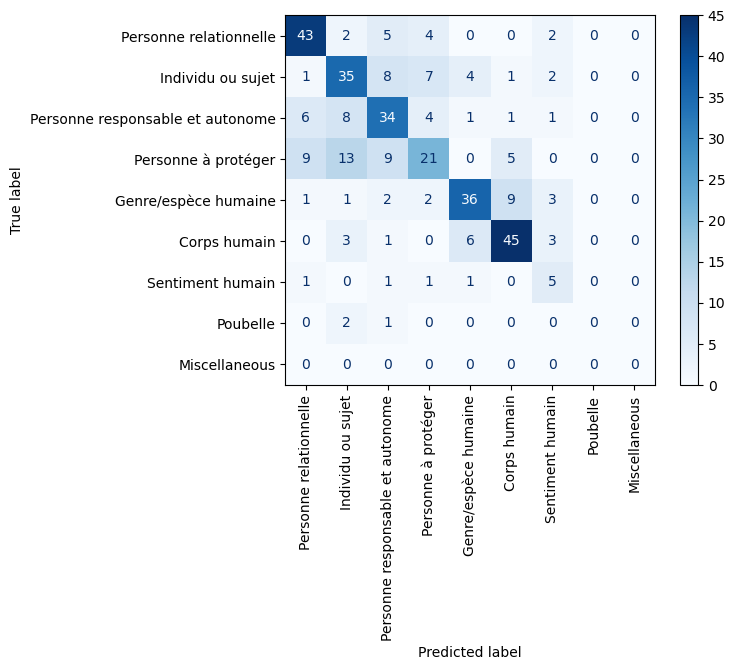

In [8]:
# Handle miscellaneous predictions
corrected_predictions = [
    prediction if prediction in unique_labels else "Miscellaneous"
    for prediction in predicted_labels
]

# Create confusion matrix
cm = confusion_matrix(true_labels, corrected_predictions, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [9]:
# Add predictions to the DataFrame
test['Predicted_Label'] = predicted_labels
test['Corrected_Prediction'] = corrected_predictions
test['Full_response'] = full_responses

# Save the DataFrame as a .pkl file
if False:
    test.to_pickle('../../data/intermediate/big/gpt/gpt_test_with_predictions.pkl')

In [28]:
pd.set_option('display.max_colwidth', None)

cat_a_corriger = "Corps humain"

test[(test['Corrected_Prediction']!=cat_a_corriger) & (test['Personne']==cat_a_corriger)].join(annotations_file[["sentence"]])[
    ["Corrected_Prediction","sentence"]
    ]

,Corrected_Prediction,sentence
sentence_id,,
1220587,Personne responsable et autonome,Il importe donc de tenir compte de toutes les modifications du comportement \nd’une personne quand on veut évaluer les processus dits « internes » liés au sentiment de soi 91.
70060,Individu ou sujet,"La circulaire Jeanneney, d'avril 1968, a précisé les caractères légaux de la mort cérébrale\ndéfinissant la mort de l'individu."
1200418,Genre/espèce humaine,"Celles-­‐ci,\t\r ou\t\r leur\t\r produit\t\r miroir,\t\r certaines\t\r duplications,\t\r ne\t\r sont\t\r que\t\r des\t\r variations\t\r de\t\r la\t\r norme,\t\r qui\t\r traduisent\t\r la\t\r diversité\t\r génétique\t\r humaine."
640042,Genre/espèce humaine,"Cependant le gène humain porte inscrits dans sa séquence des déterminants\nélémentaires fondamentaux de l'être humain ; son rapport au corps humain est, de\nce fait, d'une toute autre signification que pour d'autres molécules ; décrypter\nl'information que porte le gène, c'est ouvrir la compréhension du vivant et si ce\nvivant est humain, cette compréhension est fondamentale pour les êtres humains\nque nous sommes."
820207,Sentiment humain,Mais cette réaction s’explique aussi par le fait que très \ngénéralement la personne défigurée est l’objet d’un rejet quasi instinctif.
1320198,Individu ou sujet,"Mais , le CCNE ne dispose d’aucune précision sur le nombre actuel des opérations dans \nles premières années de la vie et sur leur nature, sinon pour les personnes atteintes \nd’hyperplasie congénitale des surrénales."
1380356,Genre/espèce humaine,"Plus largement, il a été montré que des variations génétiques associées à la schizophrénie étaient plus fréquemment retrouvées chez des \npersonnes ayant un métier artistique 65, suggérant que cette vulnérabilité génétique \npeut, dans certains cas (selon le contexte génétique et environnemental), être une \nsource de richesse pour la personne et la société."
1380414,Genre/espèce humaine,"L’humilité comme contrepoids à l’hubris : l’humilité scientifique \nLes mutations génétiques faisant partie de la constitution même de l’individu, tout \ncomme les variations chromosomiques, la question se pose de savoir si ces mutations \nrelèvent d’une patholo gie ou d’une simple différence participant à la diversité de \nl’espèce humaine."
820132,Genre/espèce humaine,"Les visages des masques de théâtre ont la forme d’un \nvisage, mais nul ne songerait à les confondre avec un visage humain."


In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming 'test' is your DataFrame containing the true and predicted labels

# Calculate overall metrics
accuracy = accuracy_score(test['Personne'], test['Corrected_Prediction'])
f1 = f1_score(test['Personne'], test['Corrected_Prediction'], average='weighted')
precision = precision_score(test['Personne'], test['Corrected_Prediction'], average='weighted')
recall = recall_score(test['Personne'], test['Corrected_Prediction'], average='weighted')

# Print overall metrics
print("Overall Metrics:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Calculate metrics for each category
unique_labels = test['Personne'].unique()
f1_per_category = f1_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)
precision_per_category = precision_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)
recall_per_category = recall_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Category': unique_labels,
    'Precision': precision_per_category,
    'Recall': recall_per_category,
    'F1-Score': f1_per_category})

# Display the DataFrame
print(metrics_df)


Overall Metrics:
Accuracy: 0.6257142857142857
F1 Score: 0.6205804407846831
Precision: 0.6246902585119799
Recall: 0.6257142857142857

                           Category  Precision    Recall  F1-Score
0            Personne relationnelle   0.704918  0.767857  0.735043
1                 Individu ou sujet   0.546875  0.603448  0.573770
2  Personne responsable et autonome   0.557377  0.618182  0.586207
3               Personne à protéger   0.538462  0.368421  0.437500
4              Genre/espèce humaine   0.750000  0.666667  0.705882
5                      Corps humain   0.737705  0.775862  0.756303
6                  Sentiment humain   0.312500  0.555556  0.400000
7                          Poubelle   0.000000  0.000000  0.000000


c:\Users\leopo\anaconda3\envs\ccne\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leopo\anaconda3\envs\ccne\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
